#  数据收集与预处理

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 设置可视化风格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
# 文件读取
driver_activity=pd.read_csv(r'H:\data_set\Driver_retained\driver_activity.csv',parse_dates=['date'])
driver_churn=pd.read_csv(r'H:\data_set\Driver_retained\driver_churn_status.csv',parse_dates=['churn_date'])
driver_info=pd.read_csv(r'H:\data_set\Driver_retained\driver_info.csv',parse_dates=['registration_date'])
driver_orders=pd.read_csv(r'H:\data_set\Driver_retained\driver_orders.csv',parse_dates=['order_time', 'complete_time'])

In [3]:
# 数据清洗与整合
driver_info.dropna(subset=['driver_id', 'registration_date'], inplace=True)
driver_activity.fillna({'online_hours': 0, 'order_count': 0, 'daily_income': 0}, inplace=True)

In [4]:
# 整合行为、基础信息、流失数据
driver_df = driver_activity.merge(driver_info, on='driver_id', how='left')
driver_df = driver_df.merge(driver_churn, on='driver_id', how='left')

In [5]:
# 最后活跃日识别与流失状态打标
last_active = driver_activity.groupby('driver_id')['date'].max().reset_index()
last_active['is_churned'] = last_active['date'] < (driver_activity['date'].max() - pd.Timedelta(days=30))
driver_df = driver_df.merge(last_active[['driver_id', 'is_churned']], on='driver_id', how='left')

# 探索性数据分析

In [6]:
agg = driver_activity.groupby('driver_id').agg({
    'online_hours': 'mean',
    'daily_income': 'mean',
    'order_count': 'mean'
}).reset_index()
agg = agg.merge(last_active[['driver_id', 'is_churned']], on='driver_id')

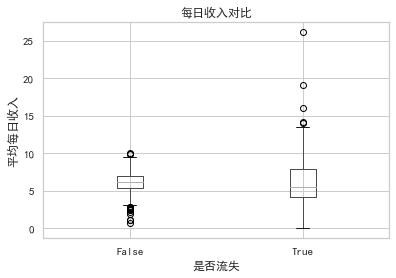

In [9]:
# 收入对比图
agg.boxplot(column='daily_income', by='is_churned')
plt.title('每日收入对比')
plt.suptitle('')
plt.xlabel('是否流失')
plt.ylabel('平均每日收入')
plt.show()

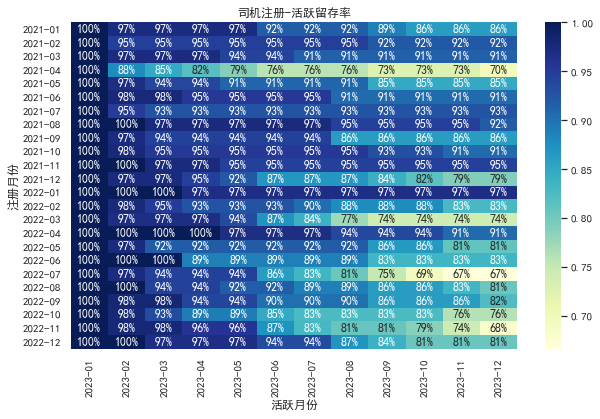

In [10]:
# 同期群分析 Cohort 
driver_df['reg_month'] = driver_df['registration_date'].dt.to_period('M')
driver_df['active_month'] = driver_df['date'].dt.to_period('M')
cohort = driver_df.groupby(['reg_month', 'active_month'])['driver_id'].nunique().reset_index()
cohort_pivot = cohort.pivot(index='reg_month', columns='active_month', values='driver_id')
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('司机注册-活跃留存率')
plt.xlabel('活跃月份')
plt.ylabel('注册月份')
plt.show()

              daily_income  online_hours  order_completion_rate
is_churned_y                                                   
False             6.160521      2.908791               0.069669
True              5.762578      2.880580               0.065320


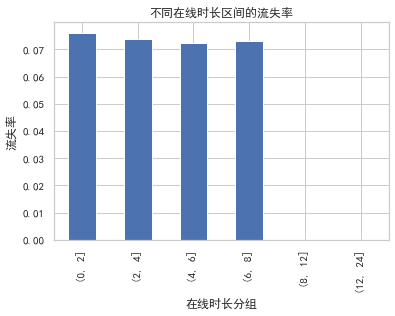

In [17]:
# 分析关键流失因素
driver_df['order_completion_rate'] = driver_df['completed_order_count'] / driver_df['order_count'].replace(0, 1)
driver_df['online_hours_bin'] = pd.cut(driver_df['online_hours'], bins=[0,2,4,6,8,12,24])

# 各因素对流失的影响
print(driver_df.groupby('is_churned_y')[['daily_income', 'online_hours', 'order_completion_rate']].mean())

# 分组流失率对比
grouped = driver_df.groupby('online_hours_bin')['is_churned_y'].mean()
grouped.plot(kind='bar', title='不同在线时长区间的流失率')
plt.ylabel('流失率')
plt.xlabel('在线时长分组')
plt.show()
